In [1]:
pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=848e83b7c6e059053e1880ffda15fdd20017995aa1e3c738c93c8c3c95616763
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [2]:
import requests
import wikipedia
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [3]:
# Funktion zum Erhalten der Wikipedia-URL, erlaubt bis zu 2 Tippfehler und wirft bestes Ergebnis aus: 

def getURL(keyword):
  S = requests.Session()
  URL = "https://en.wikipedia.org/w/api.php"
  PARAMS = {
    "action": "opensearch",
    "search": keyword,
    "limit": "1",
    "format": "json", 
    'profile': 'fuzzy'
    }
  R = S.get(url=URL, params=PARAMS)
  got = R.json()
  wikititle = got[3]
  wt1 = ''.join(str(e) for e in wikititle)
  #print(wt1)
  return wt1

In [13]:
wikiurl = getURL('natural language processin')
wikiurl

'https://en.wikipedia.org/wiki/Natural_language_processing'

In [5]:
# vereinfachte Funktion zum Erhalten des reinen Seitentextes (ohne Rücksichtnahme auf Formeln, Verweise etc. -> werden mit NLTK-Funktion in Folge entfernt)

def getBlankText(keyword):
  url = getURL(keyword)
  x = url.split(sep="/", maxsplit=-1)[-1:]
  page = wikipedia.page(x[-1:])
  content = page.content.replace('\n', '')
  print(page)
  print(content[0:50],'...')
  return content

In [6]:
page1 = getBlankText('natural langage processing')

<WikipediaPage 'Natural language processing'>
Natural language processing (NLP) is a subfield of ...


In [7]:
# Funktion zum Erhalten der Vokabeldichte, inkl. Ausschließen von Sonderzeichen, Abkürzungen, Füllwörtern etc. via NLTK

def getVD(keyword):
  url = getURL(keyword)
  text = getBlankText(keyword)
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  nn = []
  ok = 'NN' 
  for i in tagged:
    if ok == i[1]:
      nn.append(i[0])
  nn1 = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in nn]
  nn2 = []
  for i in nn1:
    if len(i) > 2:
      nn2.append(i)
  VD = len(np.unique(nn2)) / len(nn2)
  print('vocabulary density: ', VD)
  return VD

In [8]:
getVD('natural language processing')

<WikipediaPage 'Natural language processing'>
Natural language processing (NLP) is a subfield of ...
vocabulary density:  0.4387019230769231


0.4387019230769231

In [9]:
# Funktion zum Erhalten der Wörter pro Satz; 

##### TODO: Kontrolle, ob weitere Satzenden definiert werden müssen #####

def getWPS(keyword):
  url = getURL(keyword)
  text = getBlankText(keyword)
  words = text
  sentences = [[]]
  ends = set(".?!;")
  for word in words:
    if word in ends: sentences.append([])
    else: sentences[-1].append(word)
  if sentences[0]:
    if not sentences[-1]: sentences.pop()
    wps = sum(len(s) for s in sentences)/len(sentences)
    print("average words per sentence: ", wps)
    return wps

In [10]:
getWPS('natural language processin')

<WikipediaPage 'Natural language processing'>
Natural language processing (NLP) is a subfield of ...
average words per sentence:  114.7243816254417


114.7243816254417

In [11]:
# Funktion zum Plotten von wps und vd 

##### TODO: evtl. noch Radius normalisiert darstellen, im Moment noch durch Kommaverschiebung gelöst #####

def getWordPlot(keyword):
  VD = getVD(keyword)
  wps = getWPS(keyword)

  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 4)) 
  [axi.set_axis_off() for axi in ax.ravel()]

  cmap = mpl.cm.cool
  norm = mpl.colors.Normalize(vmin=0, vmax=5)

  ax[0,0] = fig.add_subplot()
  wpscircle = plt.Circle((0.1, 0.1 ), radius=wps/10, fill=True, color = cmap(norm(wps/10)))
  ax[0,0].add_patch(wpscircle)
  label = ax[0,0].annotate('WpS', xy = (0.1, 0.1), fontsize = 15, ha='center')
  ax[0,0].set_aspect(1)
  ax[0,0].autoscale_view()
  ax[0,0].axis('off')

  ax[0,1] = fig.add_subplot()
  vdcircle = plt.Circle((10.1, 0.1 ), radius=VD*10, fill=True, color = cmap(norm(VD*10)))
  ax[0,1].add_patch(vdcircle)
  label = ax[0,1].annotate('VD', xy = (10.1, 0.1), fontsize = 15, ha='center')
  ax[0,1].set_aspect(1)
  ax[0,1].autoscale_view()
  ax[0,1].axis('off')

  fig, ax = plt.subplots(figsize=(8, 0.5))
  fig.subplots_adjust(bottom=0.5)

  cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal')

  cbar.set_ticks(np.arange(0, 10, 2.5))
  cbar.set_ticklabels(['low', 'medium', 'high'])

  plt.show()

<WikipediaPage 'Natural language processing'>
Natural language processing (NLP) is a subfield of ...
vocabulary density:  0.4387019230769231
<WikipediaPage 'Natural language processing'>
Natural language processing (NLP) is a subfield of ...
average words per sentence:  114.7243816254417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


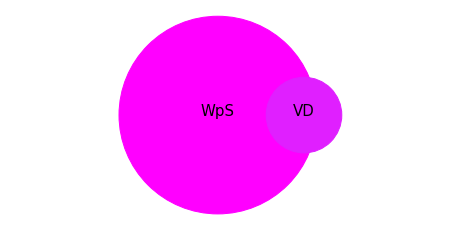

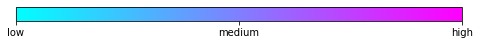

In [12]:
getWordPlot('natural language processing')